## File created by Reid Wyde


### Last updated 11.1.19


# Data driven growth models for Adjuvant Therapy for HER2+ Breast Cancer

## Traversing differential equations parameter space using Markov Chain Monte Carlo

#### Background: Chemotherapy (Doxorubicin) and immunotherapy (Trastuzumab/Herceptin) were given to adult female rats previously injected with HER2+ breast cancer [ ]. Trastuzumab is understood to improve vascular regularization within tumors and improve chemotherapy efficacy [ ]. This project investigates growth models for HER2+ cancer in the presence of different combinations of Doxorubicin and Trastuzumab. The goal is to deliver a data validated growth model that informs optimal treatment using these therapies, as well as characterize the tumoral system, including the relationship between tumor size, natural growth rate, drug clearing rate, and magnitude of drug effect.

### Mathematical models of tumor growth and simulation visualizations provided by Dr. Ernesto Lima, Associate Researcher at The Center for Computational Oncology at The University of Texas, 2019. 

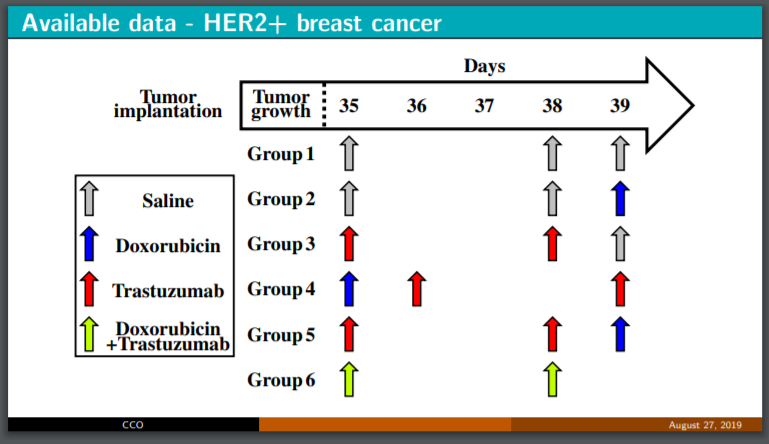

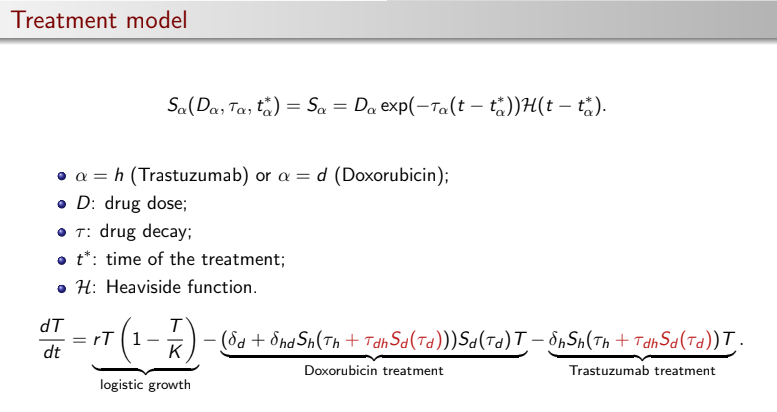

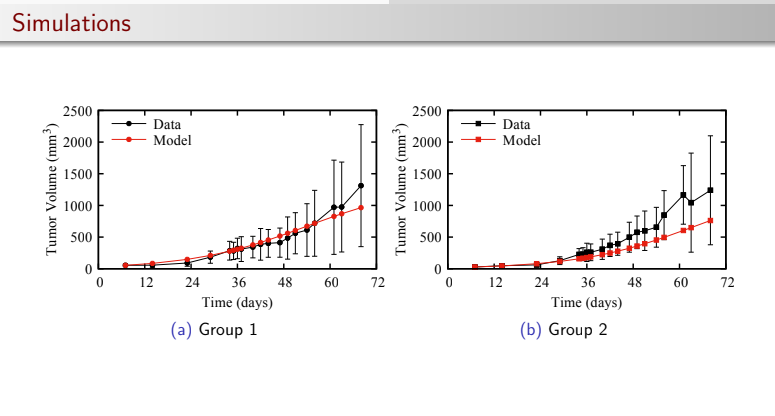

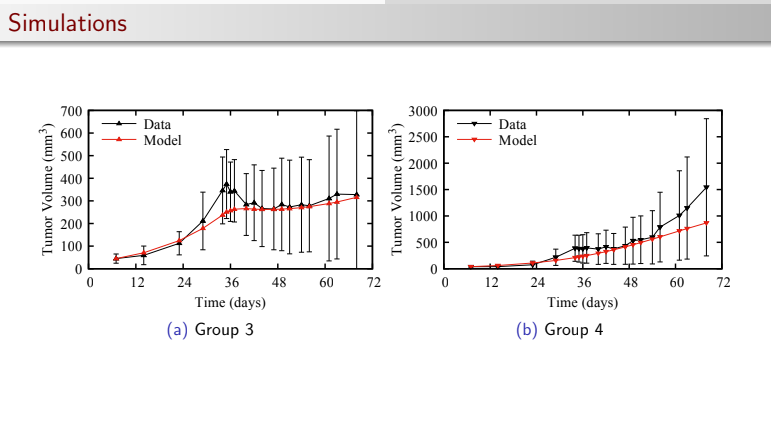

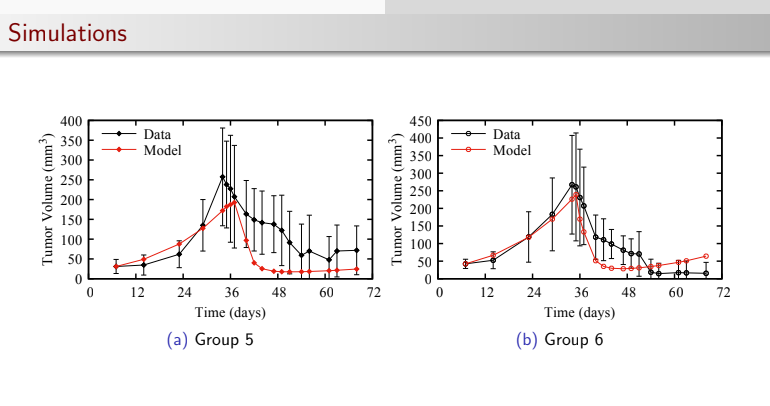

Simulation Parameters found: 

        r = 6.773495e-02
        K = 1.331254e+03
        delta_h = 3.165840e-02
        tau_h = 1.696031e-02
        delta_d = 6.548050e-05
        tau_d = 3.001805e-01
        delta_dh = 4.327301e-01
        tau_dh = 9.344758e+03

## Note: From here on, groups will be 0 indexed. i.e. group 0 is the control, group 5 is the simultaneous combination therapy

## General Strategy:  We will fit parameters one group at a time. Group 0 will parameterize the natural growth rate of cancer. Group 1 will parameterize Doxorubicin in isolation. Group 2 will parameterize Herceptin (Trastuzumab) in isolation. Groups 3, 4, and 5 will parameterize the drug-drug interaction. 


## This greedy strategy is motivated by the understanding that MCMC doesn't converge effectively for large dimensionality, models tend to get stuck. 

## New Model Iteration: Time Delay

### If we take drug delivery to be non instantaneous, we have many choices for modifying the shape of the treatment curve.

### We hypothesize the following treatments:

$$ S_d = (\tau_d\times(t-tt))\times e^{((1-\tau_d)\times(t-tt))}\times u(t-tt)) $$


$$ S_h = (\tau_d + \tau_{dh} \times S_d) \times (t-tt) ) \times e^{(1-(\tau_h + \tau_{dh} \times S_d))(t-tt)} \times u(t-tt) $$


# Code

In [7]:
#visualization
import matplotlib.pyplot as plt

#arrays
import numpy as np

#file system
import os
import platform

#CSV read
import pandas as pd

#model building
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

np.random.seed(123)

In [8]:
if platform.system() == 'Windows':  # check the file system formatting
    filename = os.getcwd() + '\..\data\\tumor_size_db.csv'
else:
    filename = os.getcwd() + '/../data//tumor_size_db.csv'
    
tumor_size_db = pd.read_csv(filename)
#tumor_size_db.head()

In [9]:
ts = np.array(tumor_size_db['Day']).transpose() # dimension: (19,)
Ts = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

In [10]:
def get_tt(tuple_treatment_group):
    switcher={
        ('dox',1): [39],
        
        ('her',2): [35,38],
        
        ('dox',3): [35],
        ('her',3): [36,39],
        
        ('her',4): [35,38],
        ('dox',4): [39],
        
        ('her',5): [35,38],
        ('dox',5): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])

## Treatment concentration model

In [11]:
def get_Sd(tau_d, t):
    Sd = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('dox',group))
        for tt in treatment_times:
            Sd[group] = Sd[group] + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh(tau_h, tau_dh, Sd, t):
    Sh = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('her',group))
        for tt in treatment_times:
            tau = tau_h + tau_dh*Sd            
            # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
            # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
            # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
            Sh[group] = Sh[group] + np.nan_to_num(np.exp(-tau[group]*(t-tt)))*np.heaviside(t-tt, 0) 
    return Sh


def get_Sd_by_group(tau_d, t, group): 
    Sd = 0
    treatment_times = get_tt(('dox',group))
    for tt in treatment_times:
        Sd = Sd + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh_by_group(tau_h, tau_dh, Sd, t, group):
    Sh = 0
    treatment_times = get_tt(('her',group))
    for tt in treatment_times:
        tau = tau_h + tau_dh*Sd            
        # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
        # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
        # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
        Sh = Sh + np.nan_to_num(np.exp(-tau*(t-tt)))*np.heaviside(t-tt, 0) 
    return Sh




### If we take drug delivery to be non instantaneous, we have many choices for modifying the shape of the treatment curve.

### We hypothesize the following treatments:

$$ S_d = (\tau_d\times(t-tt))\times e^{((1-\tau_d)\times(t-tt))}\times u(t-tt)) $$


$$ S_h = (\tau_d + \tau_{dh} \times S_d) \times (t-tt) ) \times e^{(1-(\tau_h + \tau_{dh} \times S_d))(t-tt)} \times u(t-tt) $$

In [12]:
def get_Sd_time_delay(tau_d, t):
    Sd = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('dox',group))
        for tt in treatment_times:
            Sd[group] = Sd[group] + (tau_d * (t-tt)) * np.exp((1-tau_d)*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh_time_delay(tau_h, tau_dh, Sd, t):
    Sh = np.zeros((6,))
    tau = tau_h + tau_dh*Sd 
    for group in range(6):
        treatment_times = get_tt(('her',group))
        for tt in treatment_times:
            # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
            # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
            # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
            #Sh[group] = Sh[group] + np.nan_to_num(np.exp(-tau[group]*(t-tt)))*np.heaviside(t-tt, 0)
            Sh[group] = Sh[group] + (tau[group])*(t-tt)*np.nan_to_num(np.exp((1-tau[group])*(t-tt)))*np.heaviside(t-tt, 0)
    return Sh


def get_Sd_time_delay_by_group(tau_d, t, group): 
    Sd = 0
    treatment_times = get_tt(('dox',group))
    for tt in treatment_times:
        Sd = Sd + (tau_d * (t-tt)) * np.exp((1-tau_d)*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh_time_delay_by_group(tau_h, tau_dh, Sd, t, group):
    Sh = 0
    tau = tau_h + tau_dh*Sd 
    treatment_times = get_tt(('her',group))
    for tt in treatment_times:
        # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
        # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
        # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
        Sh = Sh + tau*(t-tt)*np.nan_to_num(np.exp((1-tau)*(t-tt)))*np.heaviside(t-tt, 0) 
    return Sh



#### Treatment calculation unit tests

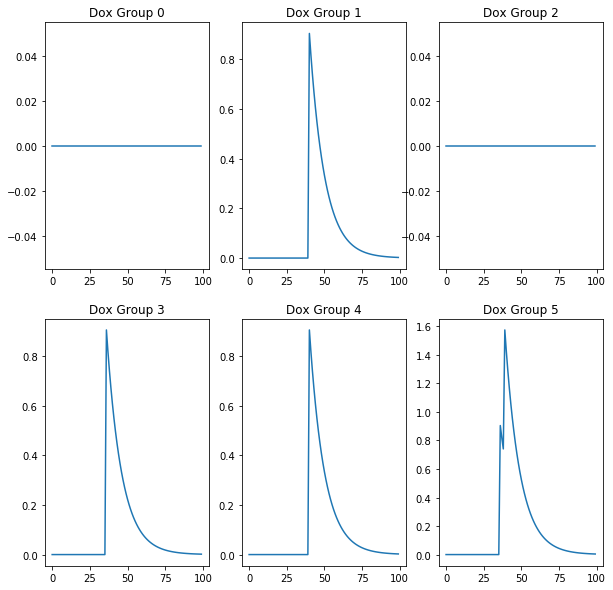

In [13]:

def test_treatment_Sd():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd(tau_d, ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd()



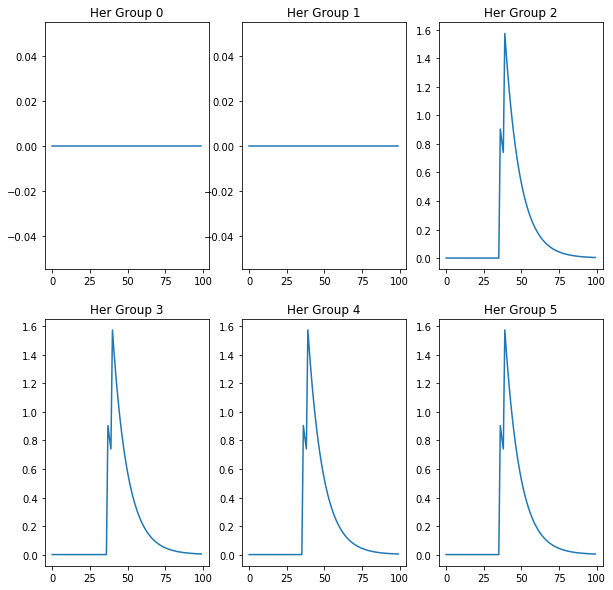

In [14]:

def test_treatment_Sh():
    tau_h=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    Sds = np.zeros((6, len(ts)))
    tau_dh = 0
    tau_d = 0
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd(tau_d, ts[ii])
        Shs[:,ii] = get_Sh(tau_h, tau_dh, Sds[:,ii], ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh()


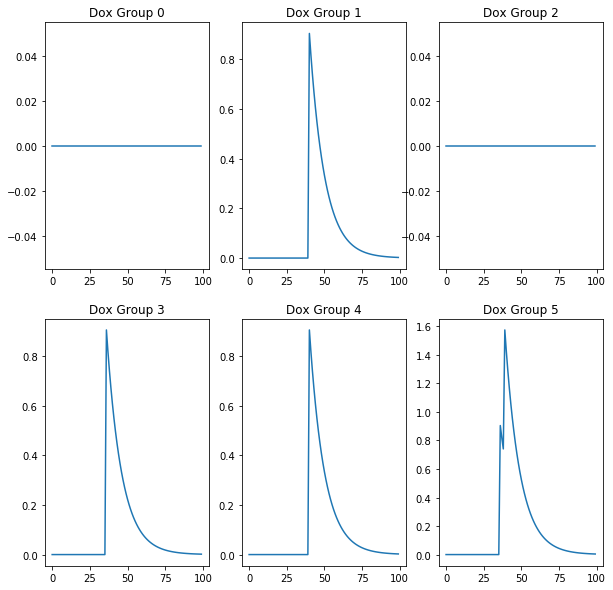

In [15]:
def test_treatment_Sd_by_group():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for ii in range(len(ts)):
        for jj in range(6):
            Sds[jj,ii] = get_Sd_by_group(tau_d, ts[ii], jj)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd_by_group()

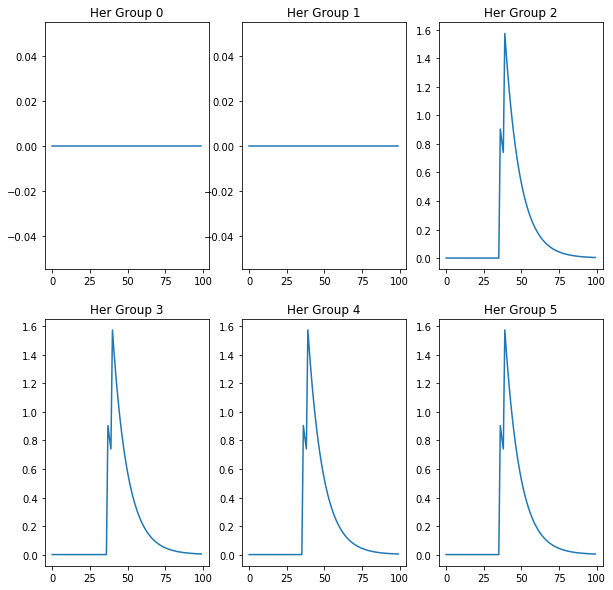

In [16]:
def test_treatment_Sh_by_group():
    tau_h=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    Sds = np.zeros((6, len(ts)))
    tau_dh = 0
    tau_d = 0
    for ii in range(len(ts)):
        for jj in range(6):
            Sds[jj,ii] = get_Sd_by_group(tau_d, ts[ii], jj)
            Shs[jj,ii] = get_Sh_by_group(tau_h, tau_dh, Sds[jj,ii], ts[ii], jj)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh_by_group()



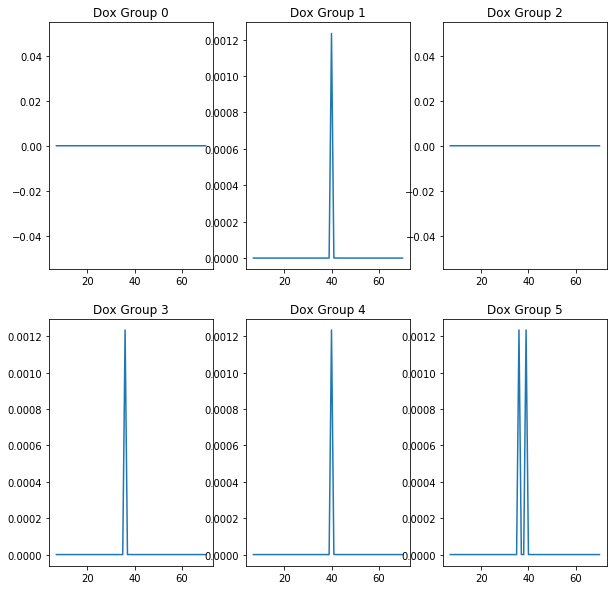

In [17]:

def test_treatment_Sd_time_delay():
    tau_d=10
    ts = np.array([int(x) for x in np.linspace(7,70,(70-7)*100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd_time_delay(tau_d, ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd_time_delay()

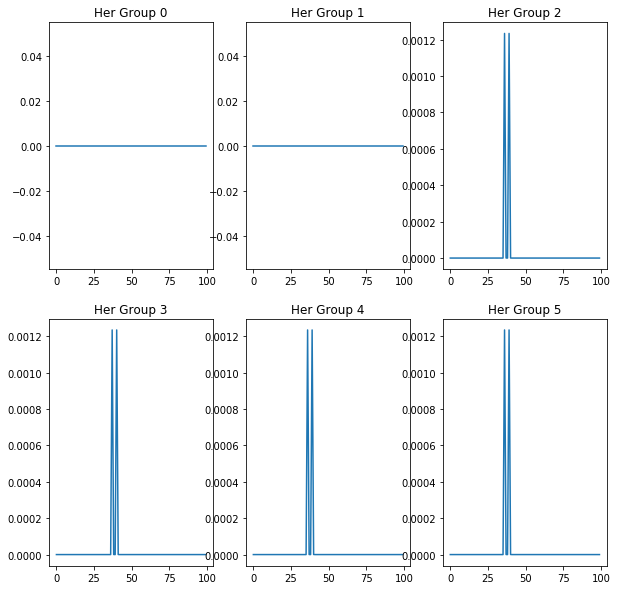

In [18]:

def test_treatment_Sh_time_delay():
    tau_h=10
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    Sds = np.zeros((6, len(ts)))
    tau_dh = 0
    tau_d = 0
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd_time_delay(tau_d, ts[ii])
        Shs[:,ii] = get_Sh_time_delay(tau_h, tau_dh, Sds[:,ii], ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh_time_delay()

## Simulation Graphing Methods

In [19]:
sim_times = np.linspace(7,70,100*(70-7+1)) # original time indexing started at day 7

def graph_sim_by_group(sim_times, T_sim, group):
    plt.figure(figsize=[4,2.5])
    plt.scatter(ts, Ts[group,:])
    plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
    plt.plot(sim_times, T_sim)
    plt.title('Group ' + str(group))
    plt.xlabel('Day')
    plt.ylabel('Size')
    plt.show()
    
def graph_sim(sim_times, T_sim):
    plt.figure(figsize=[16,10])
    for group in range(6):
        plt.subplot(2,3,group+1)
        plt.scatter(ts, Ts[group,:])
        plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
        plt.plot(sim_times, T_sim[group,:])
        plt.title('Group ' + str(group))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()

## Forward DE Models

In [20]:
def rungeKutta_multidimensional(ts, T0, dTdt, params): 
    time_len = len(ts.ravel())
    ret = np.zeros((len(T0), time_len))
    ret[:,0] = T0
    T = T0
    for i in range(1,time_len):
        T = T.clip(min=0)
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dTdt(t, T, params) 
        k2 = h * dTdt(t+0.5*h, T + 0.5 * k1, params) 
        k3 = h * dTdt(t+0.5*h, T + 0.5 * k2, params) 
        k4 = h * dTdt(t+h, T + k3, params) 
        T = T + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        T[T<0] = 0
        ret[:,i] = T
    return ret


def rungeKutta(ts, T0, dTdt, params): 
    time_len = len(ts.ravel())
    ret = np.zeros((1, time_len))
    ret[0,0] = T0
    T = T0
    for i in range(1,time_len):
        T = T.clip(min=0)
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dTdt(t, T, params) 
        k2 = h * dTdt(t+0.5*h, T + 0.5 * k1, params) 
        k3 = h * dTdt(t+0.5*h, T + 0.5 * k2, params) 
        k4 = h * dTdt(t+h, T + k3, params) 
        T = T + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        ret[0,i] = max(T, 0)
    return ret


## Growth Model Class

In [21]:
class growth_model(object):
    def __init__(self, times, T0):
        self._times = times
        self._T0 = T0

    def _simulate(self, params, times):
        values = rungeKutta(times, self._T0, self.dTdt, params)
        return values
   
    def get_param(self, param_name, n=10):
        return pm.summary(self.trace)['mean'][param_name]

## Logistic Growth Model
### Used to fit to group 0 data

Only 200 samples in chain.
Sequential sampling (10 chains in 1 job)
CompoundStep
>Slice: [K]
>Slice: [r]
100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:04<00:00, 57.37it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


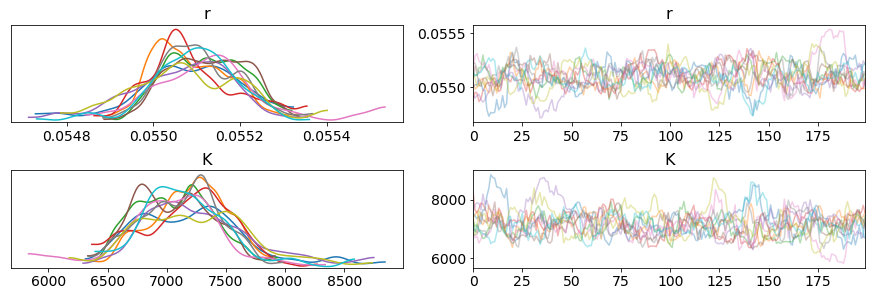

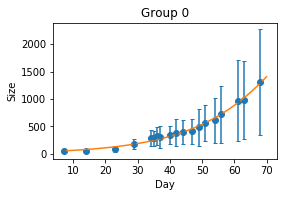

r: 0.05509823682358656
K: 7161.356830067187


In [35]:
class growth_model_natural(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[0,0])
    
    def simulate(self, r, K, times=None):
        if times is None: times = self._times        
        return self._simulate([r, K], times)
    
    def dTdt(self, t, T, params):
        r, K = [x for x in params] 
         
        return T*r*(1-(T/K))
    
    def backward(self):
        T_obs = Ts[0,:]
        sigmas_obs = sigmas[0,:]/100
        with pm.Model():
            self.param_list = ['r', 'K']
            r_lower = 0.0
            r_upper = 0.1
            K_lower = 0.0
            K_upper = 20000
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            K = pm.Uniform('K', lower=K_lower, upper=K_upper)

            ## Theano wrapper is necessary in order to pass the forward evolution to PyMC3
            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, K):
                th_states = self.simulate(r, K)
                return th_states
            
            forward = th_forward_model(r, K)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 10 # more is better. This is how the MCMC calculation is easily distributed between cores
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       'K':np.random.uniform(K_lower, K_upper),                     
                      } for _ in range(n_chains)]
            num_samples = 200 # longer is better. Within each chain, operations are sequential and cannot be parallelized.
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace)
            
            
            
    def fit_sim_graph_model():
        this_model = growth_model_natural()
        this_model.backward()
        r, K = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(r, K, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 0)
        print('r: ' + str(r))
        print('K: ' + str(K))

        return r, K


            
r, K = growth_model_natural.fit_sim_graph_model()

### Dr. Ernesto Lima's Findings, for reference

r = 6.773495e-02

K = 1.331254e+03

## There might not be enough logistic behavior in group 1 to parameterize K. 

## Herceptin Treatment

Sequential sampling (10 chains in 1 job)
CompoundStep
>Slice: [tau_h]
>Slice: [delta_h]
100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:47<00:00,  6.51it/s]
The number of effective samples is smaller than 10% for some parameters.
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


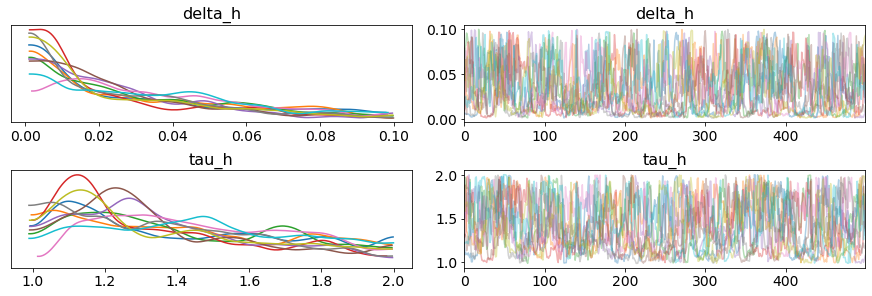

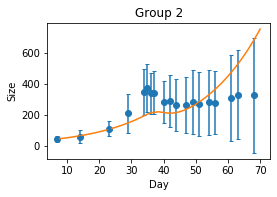

delta_h: 0.03201949799686409
tau_h: 1.4030314559965114


In [23]:
class growth_model_her(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[2,0])
    
    def simulate(self, delta_h, tau_h, times=None):
        if times is None: times = self._times        
        return self._simulate([delta_h, tau_h], times)
    
    def dTdt(self, t, T, params):
        delta_h, tau_h = [x for x in params] 
        #get_Sh_by_group(tau_h, tau_dh, Sd, t, group)
        Sh = get_Sh_time_delay_by_group(tau_h, 0, 0, t, 2) #tau_dh and Sd set to zero for this group
        return T*(r*(1-(T/K)) - delta_h*Sh)
    
    def backward(self):
        T_obs = Ts[2,:]
        sigmas_obs = sigmas[2,:]
        with pm.Model():
            self.param_list = ['delta_h', 'tau_h']
            
            delta_h_lower = 0.001
            delta_h_upper = 0.1
            
            tau_h_lower = 0.99
            tau_h_upper = 2
            
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_h, tau_h):
                th_states = self.simulate(delta_h, tau_h)
                return th_states
            
            forward = th_forward_model(delta_h, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 10
            startsmc=[{'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 500
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
            
    def fit_sim_graph_model():
        this_model = growth_model_her()
        this_model.backward()
        delta_h, tau_h = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(delta_h, tau_h, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 2)
        print('delta_h: ' + str(delta_h))
        print('tau_h: ' + str(tau_h))

        return delta_h, tau_h

            
delta_h, tau_h = growth_model_her.fit_sim_graph_model()


### Dr. Ernesto Lima's Findings, for reference

delta_h = 0.03165840

tau_h = 0.01696031


## Doxorubicin treatment

Sequential sampling (10 chains in 1 job)
CompoundStep
>Slice: [tau_d]
>Slice: [delta_d]
100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 35.28it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


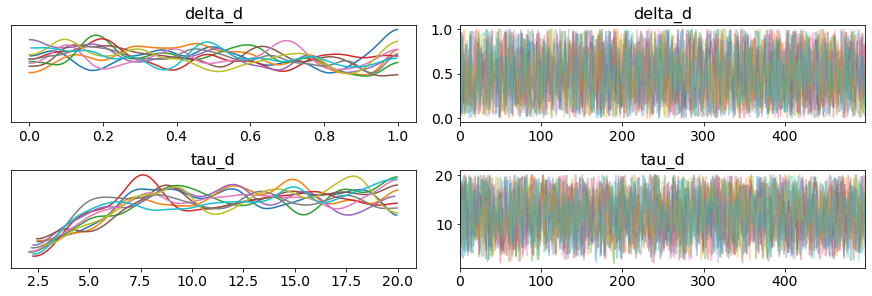

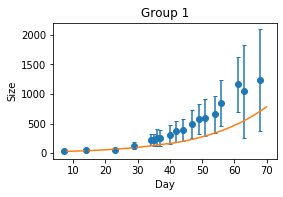

delta_d: 0.4852846336158916
tau_d: 11.955202058486714


In [24]:
class growth_model_dox(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[1,0])
    
    def simulate(self, delta_d, tau_d, times=None):
        if times is None: times = self._times        
        return self._simulate([delta_d, tau_d], times)
    
    def dTdt(self, t, T, params):
        delta_d, tau_d = [x for x in params]
        #get_Sd_by_group(tau_d, t, group)
        Sd = get_Sd_time_delay_by_group(tau_d, t, 1)
        return T*(r*(1-(T/K)) - delta_d*Sd)
    
    def backward(self):
        T_obs = Ts[1,:]
        sigmas_obs = sigmas[1,:]
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = 0 
            delta_d_upper = 1
            
            tau_d_lower = 2
            tau_d_upper = 20
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 10
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 500
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
            
    def fit_sim_graph_model():
        this_model = growth_model_dox()
        this_model.backward()
        delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(delta_d, tau_d, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 1)

        print('delta_d: ' + str(delta_d))
        print('tau_d: ' + str(tau_d))

        return delta_d, tau_d

            
delta_d, tau_d = growth_model_dox.fit_sim_graph_model()


### Dr. Ernesto Lima's Findings, for reference

delta_d = 6.548050e-05

tau_d = 3.001805e-01

## Combinational Therapy

Only 300 samples in chain.
Sequential sampling (5 chains in 1 job)
CompoundStep
>Slice: [tau_dh]
>Slice: [delta_dh]
100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [12:59<00:00,  2.81it/s]
C:\Users\Reid\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


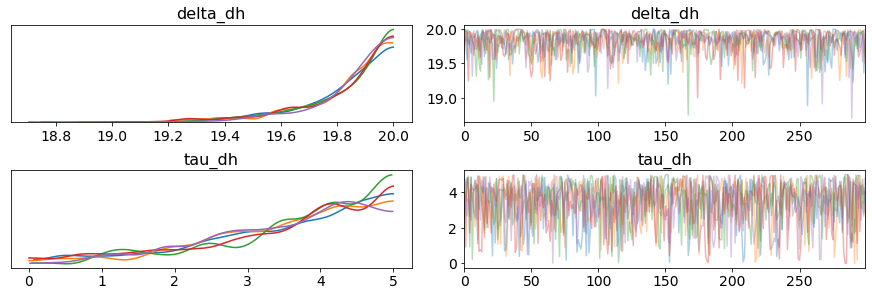

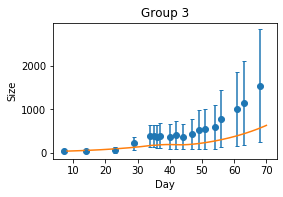

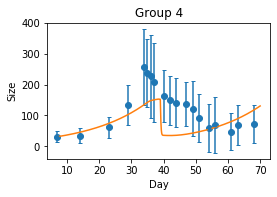

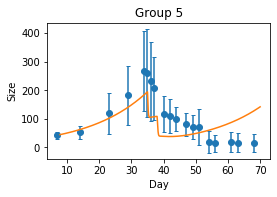

delta_dh: 0.4852846336158916
tau_dh: 11.955202058486714


In [25]:
class growth_model_dd_interaction(growth_model):
    
    def __init__(self):
        super().__init__(ts, Ts[3:6,0])
    
    
    def _simulate(self, params, times):
        values = rungeKutta_multidimensional(times, self._T0, self.dTdt, params)
        return values
    
    def simulate(self, delta_dh, tau_dh, times=None):
        if times is None: times = self._times        
        return self._simulate([delta_dh, tau_dh], times)
    
    def dTdt(self, t, T, params):
        delta_dh, tau_dh = [x for x in params]
        
        #get_Sd(tau_d, t)
        #get_Sh(tau_h, tau_dh, Sd, t)
                   
        Sd = get_Sd_time_delay(tau_d, t)
        Sh = get_Sh_time_delay(tau_h, tau_dh, Sd, t)
        
        Sd = Sd[3:]
        Sh = Sh[3:]
        
        #print('T len ' + str(len(T)))
        #print('Sd len ' + str(len(Sd)))
        #print('Sh len ' + str(len(Sh)))
        
        
        return  T*(r*(1-(T/K)) - (delta_d + delta_dh*Sh)*Sd - delta_h*Sh)
    
    def backward(self):
        T_obs = Ts[3:6,:]
        sigmas_obs = sigmas[3:6,:]
        with pm.Model():
            self.param_list = ['delta_dh', 'tau_dh']
            delta_dh_lower = 0
            delta_dh_upper = 20
            tau_dh_lower = 0
            tau_dh_upper = 5

            delta_dh = pm.Uniform('delta_dh', lower=delta_dh_lower, upper=delta_dh_upper)
            tau_dh = pm.Uniform('tau_dh', lower=tau_dh_lower, upper=tau_dh_upper)
            

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_dh, tau_dh):
                th_states = self.simulate(delta_dh, tau_dh)
                return th_states
            
            forward = th_forward_model(delta_dh, tau_dh)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 5
            startsmc=[{'delta_dh':np.random.uniform(delta_dh_lower, delta_dh_upper),
                       'tau_dh':np.random.uniform(tau_dh_lower, tau_dh_upper),   
                      } for _ in range(n_chains)]
            num_samples = 300
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    
    def fit_sim_graph_model():
        this_model = growth_model_dd_interaction()
        this_model.backward()
        delta_dh, tau_dh = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(delta_dh, tau_dh, sim_times)
        graph_sim_by_group(sim_times, T_sim[0,:].reshape(-1,1), 3)
        graph_sim_by_group(sim_times, T_sim[1,:].reshape(-1,1), 4)
        graph_sim_by_group(sim_times, T_sim[2,:].reshape(-1,1), 5)

        print('delta_dh: ' + str(delta_d))
        print('tau_dh: ' + str(tau_d))

        return delta_d, tau_d

            
delta_dh, tau_dh = growth_model_dd_interaction.fit_sim_graph_model()

## Dr. Ernesto Lima's findings, for reference

delta_dh = 4.327301e-01

tau_dh = 9.344758e+03

## My findings

In [26]:
print('r = ' + str(r))
print('K = ' + str(K))
print('delta_d = ' + str(delta_d))
print('tau_d = ' + str(tau_d))
print('delta_h = ' + str(delta_h))
print('tau_h = ' + str(tau_h))
print('delta_dh = ' + str(delta_dh))
print('tau_dh = ' + str(tau_dh))

r = 0.05497774464293899
K = 9816.093043121215
delta_d = 0.4852846336158916
tau_d = 11.955202058486714
delta_h = 0.03201949799686409
tau_h = 1.4030314559965114
delta_dh = 0.4852846336158916
tau_dh = 11.955202058486714


## Simulate parameters found by Dr. Lima


Dr. Lima's Parameters

r = 6.773495e-02
k = 1.331254e+03
delta_h = 3.165840e-02
tau_h = 1.696031e-02
delta_d = 6.548050e-05
tau_d = 3.001805e-01
delta_dh = 4.327301e-01
tau_dh = 9.344758e+03




New Params



## modified tau_dh, original model

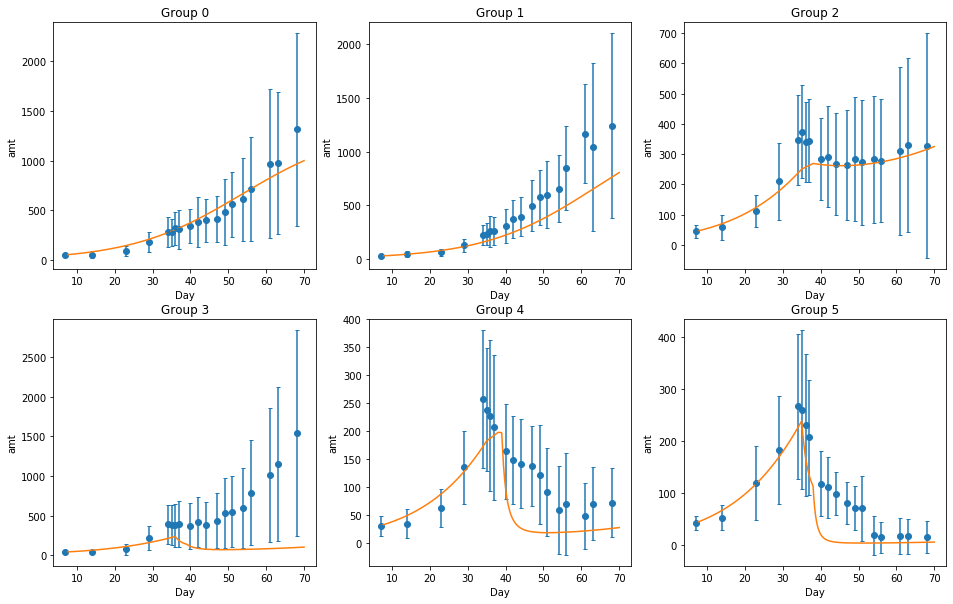

In [28]:
class growth_model_Lima(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[:,0])
        return
    
    def _simulate(self, params, times):
        values = rungeKutta_multidimensional(times, self._T0, self.dTdt, params)
        return values
    
    def simulate(self, times=None):
        if times is None: times = sim_times
        params = [6.773495e-02, 1.331254e+03, 3.165840e-02, 1.696031e-02, 6.548050e-05, 3.001805e-01,\
                  4.327301e-01, 9.344758e-03] #9.344758e+03]
        return self._simulate(params, times)
    
    def dTdt(self, t, T, params):
        #delta_d, tau_d = [x for x in params] 
        #Sd = get_Sd_group2(tau_d, t)
        
        """
        r = 6.773495e-02
        K = 1.331254e+03
        delta_h = 3.165840e-02
        tau_h = 1.696031e-02
        delta_d = 6.548050e-05
        tau_d = 3.001805e-01
        delta_dh = 4.327301e-01
        tau_dh = 9.344758e+03
        #tau_dh = 9.344758e-03
        """
        
        r, K, delta_h, tau_h, delta_d, tau_d, delta_dh, tau_dh = [x for x in params]

        Sd = get_Sd(tau_d, t)
        Sh = get_Sh(tau_h, tau_dh, Sd, t)
    
        ret =  T*(r*(1-(T/K)) - (delta_d + delta_dh * Sh)*Sd - delta_h*Sh)
    
        return ret
    
    """
    def backward(self):
        T_obs = Ts_dox
        sigmas = sigmas_dox
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = -5
            delta_d_upper = 5 
            
            tau_d_lower = -5
            tau_d_upper = 5
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 2000
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            return
        """
    def sim_graph_model():
        this_model = growth_model_Lima()
        #this_model.backward()
        #delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(sim_times)
        graph_sim(sim_times, T_sim)
        
        return T_sim

T_sim = growth_model_Lima.sim_graph_model()


## Original parameters, original model

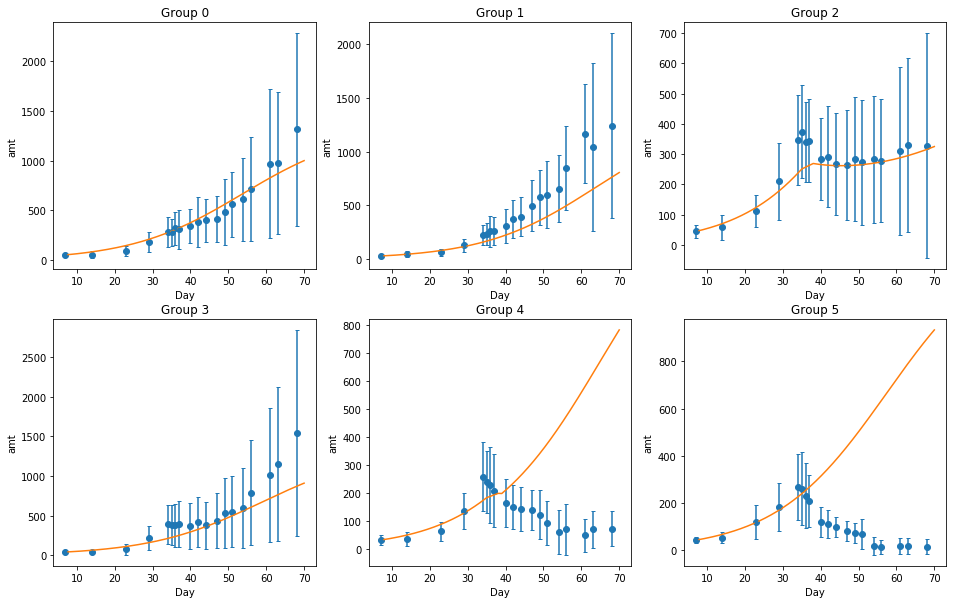

In [30]:
class growth_model_Lima(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[:,0])
        return
    
    def _simulate(self, params, times):
        values = rungeKutta_multidimensional(times, self._T0, self.dTdt, params)
        return values
    
    def simulate(self, times=None):
        if times is None: times = sim_times
        params = [6.773495e-02, 1.331254e+03, 3.165840e-02, 1.696031e-02, 6.548050e-05, 3.001805e-01,\
                  4.327301e-01, 9.344758e+03]
        return self._simulate(params, times)
    
    def dTdt(self, t, T, params):
        #delta_d, tau_d = [x for x in params] 
        #Sd = get_Sd_group2(tau_d, t)
        
        """
        r = 6.773495e-02
        K = 1.331254e+03
        delta_h = 3.165840e-02
        tau_h = 1.696031e-02
        delta_d = 6.548050e-05
        tau_d = 3.001805e-01
        delta_dh = 4.327301e-01
        tau_dh = 9.344758e+03
        #tau_dh = 9.344758e-03
        """
        
        r, K, delta_h, tau_h, delta_d, tau_d, delta_dh, tau_dh = [x for x in params]

        Sd = get_Sd(tau_d, t)
        Sh = get_Sh(tau_h, tau_dh, Sd, t)
    
        ret =  T*(r*(1-(T/K)) - (delta_d + delta_dh * Sh)*Sd - delta_h*Sh)
    
        return ret
    
    """
    def backward(self):
        T_obs = Ts_dox
        sigmas = sigmas_dox
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = -5
            delta_d_upper = 5 
            
            tau_d_lower = -5
            tau_d_upper = 5
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 2000
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            return
        """
    def sim_graph_model():
        this_model = growth_model_Lima()
        #this_model.backward()
        #delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(sim_times)
        graph_sim(sim_times, T_sim)
        
        return T_sim

T_sim = growth_model_Lima.sim_graph_model()


## new parameters

par_r = 5.477366e-02
par_k = 8.150373e+03

par_dt = 2.056754e-02 // delta tras
par_tt = 1.207568e-03 // tau tras

par_dd = 9.202416e-07 // delta doxo
par_td = 2.880215e-03 // tau doxo

par_del_td = 6.328250e-02 delta tras->doxo
par_tau_dt = 1.922454e+03 tau delta->doxo



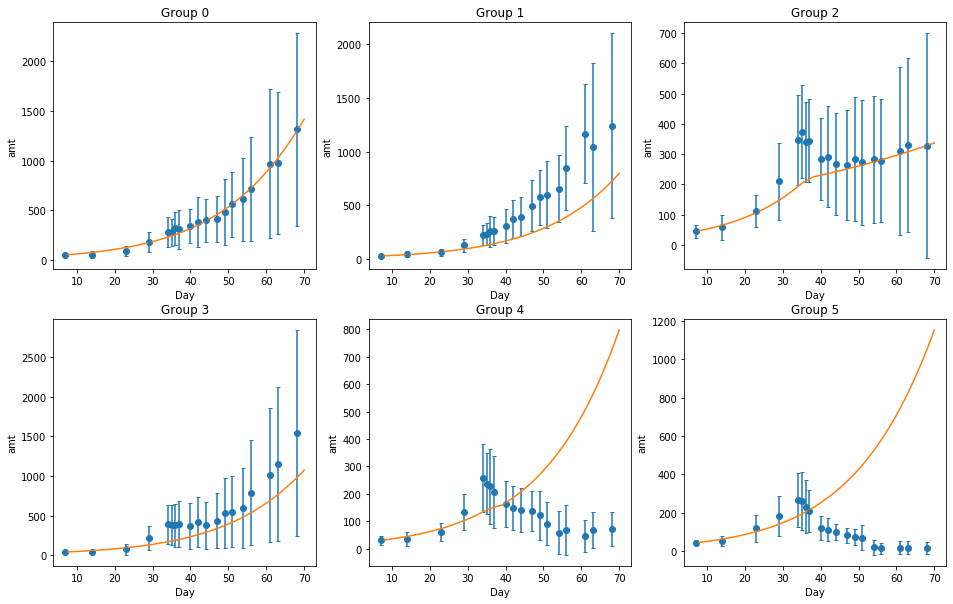

In [34]:
class growth_model_Lima_2(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[:,0])
        return
    
    def _simulate(self, params, times):
        values = rungeKutta_multidimensional(times, self._T0, self.dTdt, params)
        return values
    
    def simulate(self, times=None):
        if times is None: times = sim_times
        params = [5.477366e-02, 8.150373e+03, 2.056754e-02, 1.207568e-03, 9.202416e-07, 2.880215e-03, \
                   6.328250e-02, 1.922454e+03]
        #tau_dh = 1.922454e+03
        return self._simulate(params, times)
    
    def dTdt(self, t, T, params):
        #delta_d, tau_d = [x for x in params] 
        #Sd = get_Sd_group2(tau_d, t)
        
        """
        r = 5.477366e-02
        K = 8.150373e+03
        delta_h = 2.056754e-02
        tau_h = 1.207568e-03
        delta_d = 9.202416e-07
        tau_d = 2.880215e-03
        delta_dh = 6.328250e-02
        tau_dh = 1.922454e+03
        """
        
        r, K, delta_h, tau_h, delta_d, tau_d, delta_dh, tau_dh = [x for x in params]

        Sd = get_Sd(tau_d, t)
        Sh = get_Sh(tau_h, tau_dh, Sd, t)
    
        ret =  T*(r*(1-(T/K)) - (delta_d + delta_dh * Sh)*Sd - delta_h*Sh)
    
        return ret
    
    """
    def backward(self):
        T_obs = Ts_dox
        sigmas = sigmas_dox
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = -5
            delta_d_upper = 5 
            
            tau_d_lower = -5
            tau_d_upper = 5
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 2000
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            return
        """
    def sim_graph_model():
        this_model = growth_model_Lima_2()
        #this_model.backward()
        #delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(sim_times)
        graph_sim(sim_times, T_sim)
        
        return T_sim

T_sim = growth_model_Lima_2.sim_graph_model()
